In [14]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import graph_prep

## Loading Data, Generate Graph & Embeddings

In [2]:
data = ['preprocessed_34_10.tsv', 'preprocessed_42_10.tsv']

###### edit here to change dataset ######
dat_idx = 0 # choose from [0,1]
#########################################

file_path = "../data/" + data[dat_idx]
df = pd.read_csv(file_path, sep='\t', index_col=0)

In [3]:
G = graph_prep.nx_drug_gene_bipartite(df)

In [4]:
embedding_methods = ['node2vec', 'deepwalk']

###### edit here to change the node embedding method ######
emd_idx = 0 # choose from [0,1]
#########################################

if embedding_methods[emd_idx] == 'node2vec':
    node_embeddings = graph_prep.node2vec_embedding(G)
elif embedding_methods[emd_idx] == 'deepwalk':
    node_embeddings = graph_prep.deepwalk_embedding(G)
else:
    raise ValueError("Invalid embedding methods.")

Computing transition probabilities:   0%|          | 0/1637 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 75/75 [00:14<00:00,  5.12it/s]

## Model Functions & Configurations

In [15]:
import numpy as np
import pandas as pd
import os
import pickle
import xgboost as xgb
import torch
import torch.nn as nn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc
from scipy.stats import loguniform, randint
import matplotlib.pyplot as plt

In [16]:
# Initialize dictionaries to store metrics and models
metrics = {}
models = {}
roc_data = {}
prc_data = {}

In [17]:
# Hyperparameter distributions
lr_param_dist = {'C': loguniform(0.001, 1000)}
xgb_param_dist = {
    'learning_rate': loguniform(0.01, 0.2),
    'n_estimators': randint(50, 1000),
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'gamma': loguniform(0.001, 1),
    'subsample': loguniform(0.5, 1),
    'colsample_bytree': loguniform(0.5, 1)
}
svm_param_dist = {'C': loguniform(0.001, 1000), 'gamma': loguniform(0.001, 1)}

In [18]:
# Softmax Layer Neural Network
class SoftmaxNN(nn.Module):
    def __init__(self, input_size):
        super(SoftmaxNN, self).__init__()
        self.fc = nn.Linear(input_size, 2)

    def forward(self, x):
        return nn.functional.softmax(self.fc(x), dim=1)

In [19]:
# Function for hyperparameter tuning
def tune_hyperparameters(clf, param_dist, X_train, y_train):
    random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='roc_auc', n_jobs=-1)
    random_search.fit(X_train, y_train)
    return random_search.best_estimator_

In [28]:
# Function for training and evaluating the model
def train_evaluate_model(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_probs = clf.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_probs)

    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_probs),
        'AUC-PRC': auc(recall, precision)
    }

    roc_data = roc_curve(y_test, y_probs)
    prc_data = precision_recall_curve(y_test, y_probs)

    print("Metrics: ", end='')
    print(metrics)
    # print("AUC-ROC: ")
    # print(roc_data)
    # print("AUC-PRC: ")
    # print(prc_data)

    return metrics, roc_data, prc_data


# Function for training and evaluating the neural network
def train_evaluate_nn(model, X_train, X_test, y_train, y_test, epochs=100, learning_rate=0.001):
    # Convert data to PyTorch tensors
    X_train_torch = torch.tensor(X_train.astype(np.float32))
    X_test_torch = torch.tensor(X_test.astype(np.float32))
    y_train_torch = torch.tensor(y_train.astype(np.int64))
    y_test_torch = torch.tensor(y_test.astype(np.int64))

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        loss.backward()
        optimizer.step()

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_torch = model(X_test_torch)
        y_pred = torch.max(y_pred_torch, 1)[1].numpy()

    # Calculate metrics
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred)
    }

    return metrics

In [30]:
# # Function for plotting metrics
# def plot_metrics(roc_data, prc_data, metrics, title, save_dir):
#     fpr, tpr, _ = roc_data
#     precision, recall, _ = prc_data
#
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))
#
#     # ROC Curve
#     axs[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC AUC = {metrics["AUC-ROC"]:.2f}')
#     axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     axs[0].set_title(f'{title} - ROC Curve')
#     axs[0].set_xlabel('False Positive Rate')
#     axs[0].set_ylabel('True Positive Rate')
#     axs[0].legend(loc='lower right')
#
#     # Precision-Recall Curve
#     axs[1].plot(recall, precision, color='darkorange', lw=2, label=f'PRC AUC = {metrics["AUC-PRC"]:.2f}')
#     axs[1].set_title(f'{title} - Precision-Recall Curve')
#     axs[1].set_xlabel('Recall')
#     axs[1].set_ylabel('Precision')
#     axs[1].legend(loc='lower left')
#
#     plt.tight_layout()
#     plt.savefig(save_dir + '/' + title + '.png')
#     plt.show()


def plot_metrics(roc_data, prc_data, save_fig=False, filename='model_evaluation_plots.png'):
    # Unpack ROC data
    fpr, tpr, _ = roc_data
    # Unpack Precision-Recall data
    precision, recall, _ = prc_data

    # Create subplots
    fig, (ax_roc, ax_prc) = plt.subplots(1, 2, figsize=(12, 6))

    # Plot ROC Curve
    ax_roc.plot(fpr, tpr, color='blue', lw=2, label='ROC curve')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.set_title('ROC Curve')
    ax_roc.legend(loc="lower right")

    # Plot Precision-Recall Curve
    ax_prc.plot(recall, precision, color='green', lw=2, label='PR curve')
    ax_prc.set_xlim([0.0, 1.0])
    ax_prc.set_ylim([0.0, 1.05])
    ax_prc.set_xlabel('Recall')
    ax_prc.set_ylabel('Precision')
    ax_prc.set_title('Precision-Recall Curve')
    ax_prc.legend(loc="lower left")

    # Show the plots
    plt.tight_layout()

    # Save the figure
    if save_fig:
        plt.savefig(filename, dpi=300)

    plt.show()

## Sampling, Train-Test-Split, Dimensionality Reduction, Classification

In [22]:
import warnings
warnings.filterwarnings('ignore')

---------------------------------------------------------------------------
lr
----------------------------
Sampling Method:  random_under
PCA applied. PCA Explained Variance:  0.8964743028627709
Stratified Train-Test Split:  True
Metrics: {'Accuracy': 0.6992, 'Precision': 0.5895741556534508, 'Recall': 0.3212, 'F1-Score': 0.4158467115484205, 'AUC-ROC': 0.7245464, 'AUC-PRC': 0.5200770954115597}


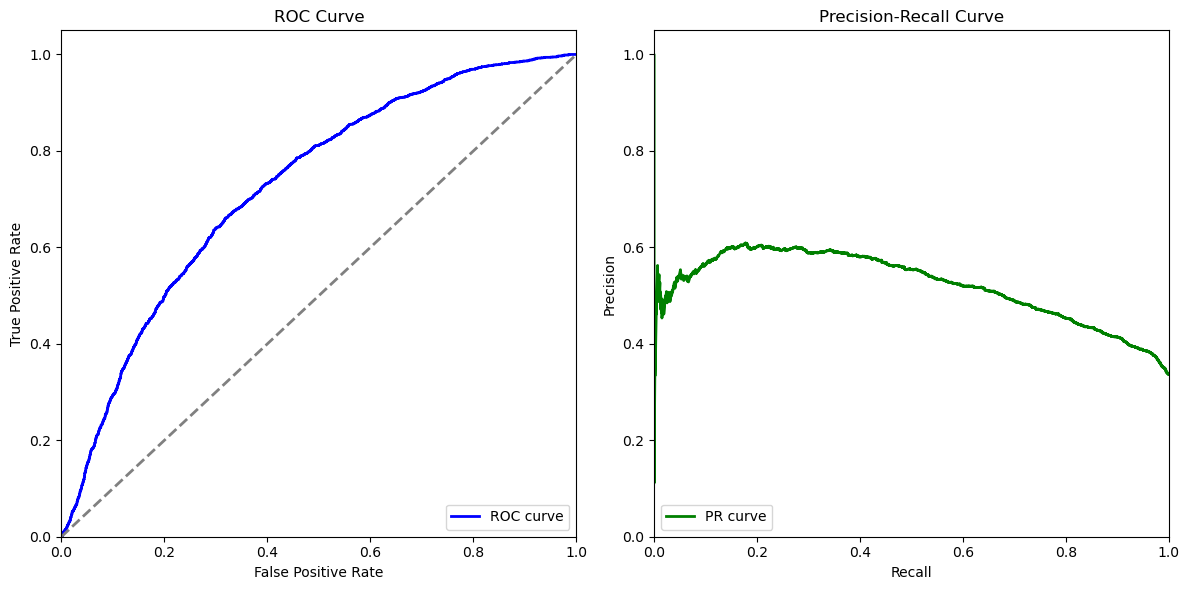

----------------------------
Sampling Method:  random_under
PCA not applied.
Stratified Train-Test Split:  True
Metrics: {'Accuracy': 0.7182666666666667, 'Precision': 0.6164960866947622, 'Recall': 0.4096, 'F1-Score': 0.49218937755347275, 'AUC-ROC': 0.7556510399999999, 'AUC-PRC': 0.5503985200484001}


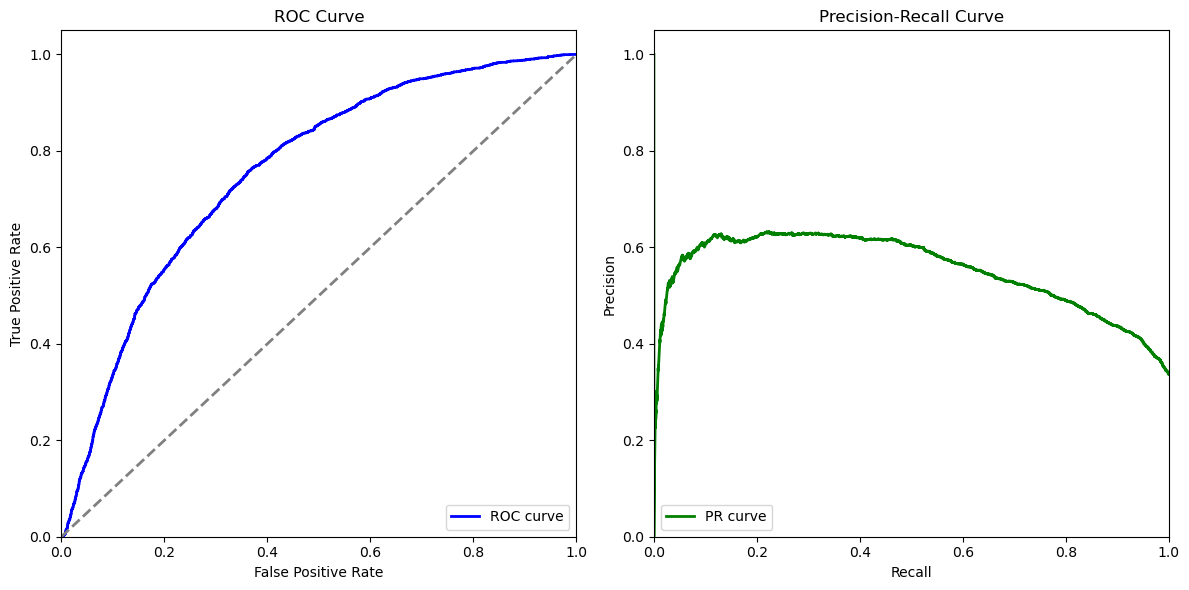

----------------------------
Sampling Method:  random_under
PCA applied. PCA Explained Variance:  0.8964744231197983
Stratified Train-Test Split:  False
Metrics: {'Accuracy': 0.6938666666666666, 'Precision': 0.5828729281767956, 'Recall': 0.33280757097791797, 'F1-Score': 0.42369477911646586, 'AUC-ROC': 0.7118952038271772, 'AUC-PRC': 0.5084146186880419}


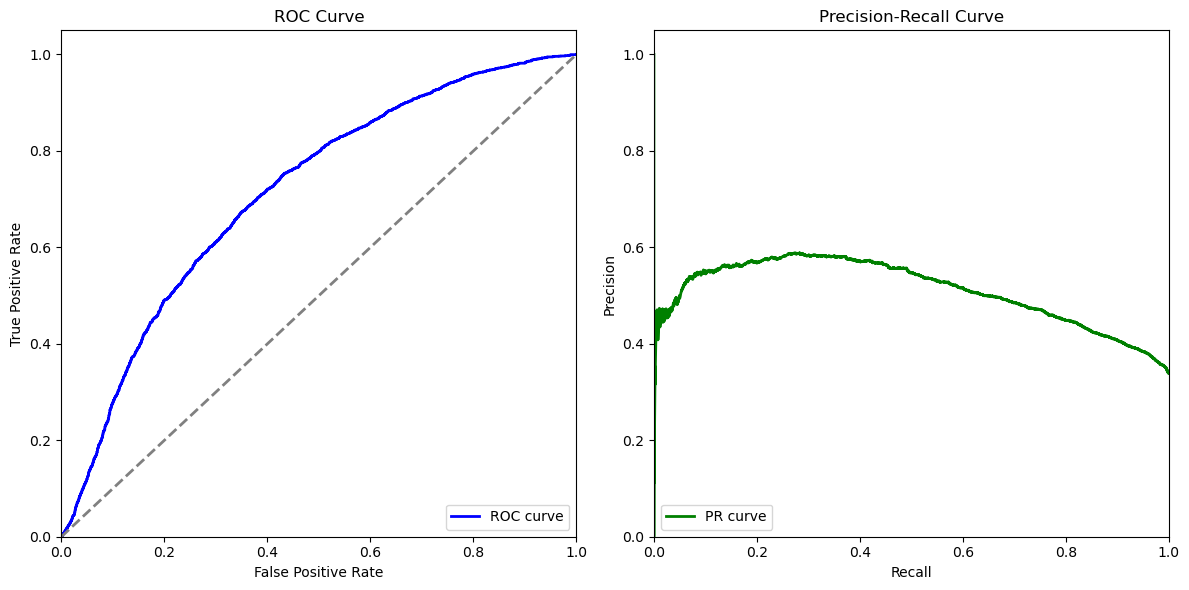

----------------------------
Sampling Method:  random_under
PCA not applied.
Stratified Train-Test Split:  False
Metrics: {'Accuracy': 0.7093333333333334, 'Precision': 0.6031286210892236, 'Recall': 0.4104889589905363, 'F1-Score': 0.4885030502111685, 'AUC-ROC': 0.7446463909231641, 'AUC-PRC': 0.541323627556531}


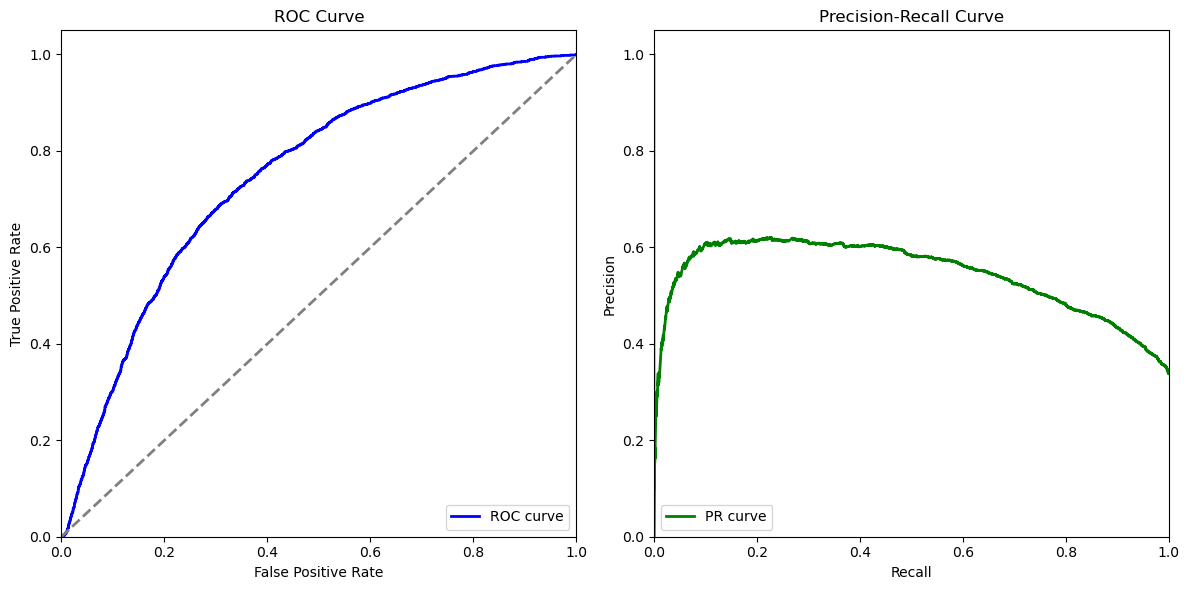

----------------------------
Sampling Method:  distance_under
PCA applied. PCA Explained Variance:  0.9187992165097967
Stratified Train-Test Split:  True
Metrics: {'Accuracy': 0.8082666666666667, 'Precision': 0.8187274909963985, 'Recall': 0.5456, 'F1-Score': 0.6548247719635141, 'AUC-ROC': 0.80974664, 'AUC-PRC': 0.7769362112283601}


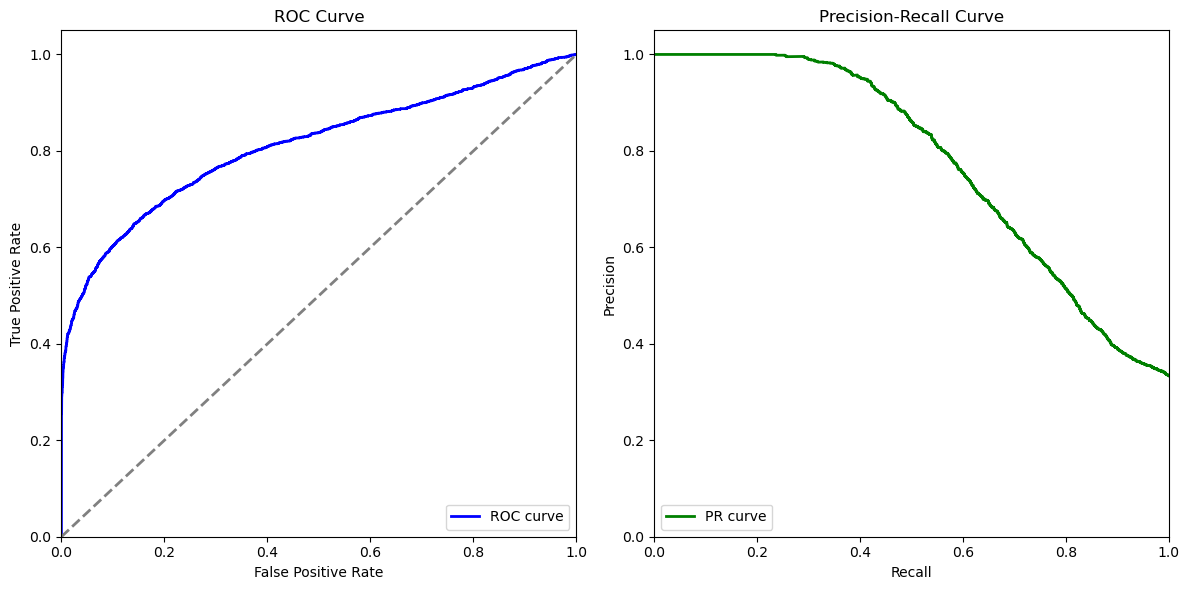

----------------------------
Sampling Method:  distance_under
PCA not applied.
Stratified Train-Test Split:  True
Metrics: {'Accuracy': 0.8286666666666667, 'Precision': 0.8653036680697535, 'Recall': 0.5756, 'F1-Score': 0.691328368964689, 'AUC-ROC': 0.83203384, 'AUC-PRC': 0.8094856943008524}


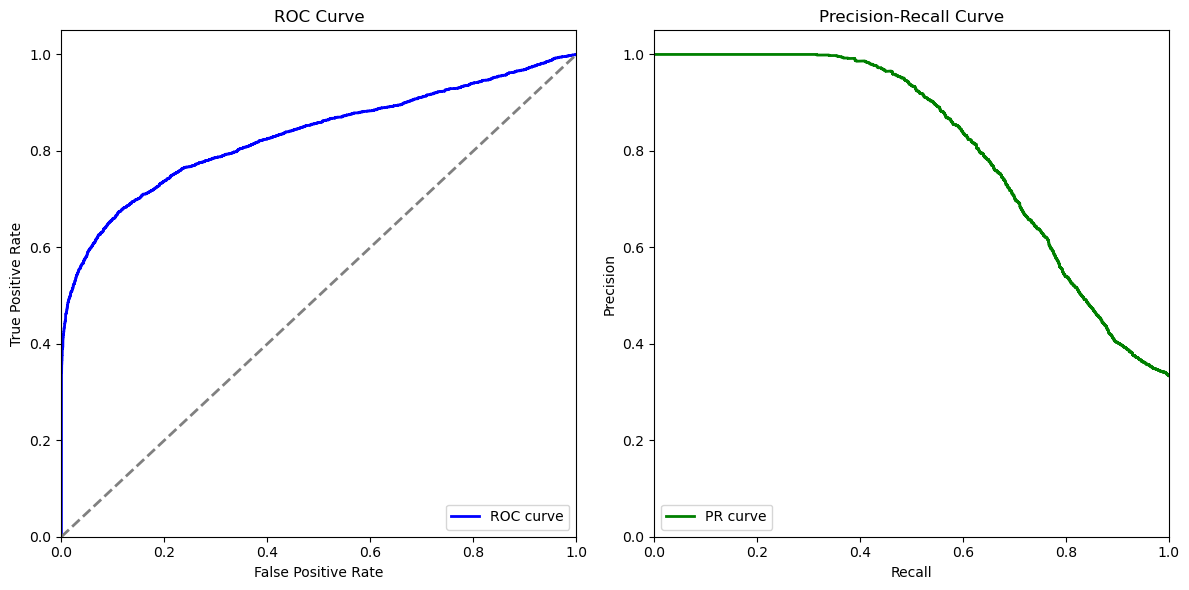

----------------------------
Sampling Method:  distance_under
PCA applied. PCA Explained Variance:  0.9188442300073802
Stratified Train-Test Split:  False
Metrics: {'Accuracy': 0.8085333333333333, 'Precision': 0.829736211031175, 'Recall': 0.5457413249211357, 'F1-Score': 0.658420551855376, 'AUC-ROC': 0.8086672782202203, 'AUC-PRC': 0.7807239977490525}


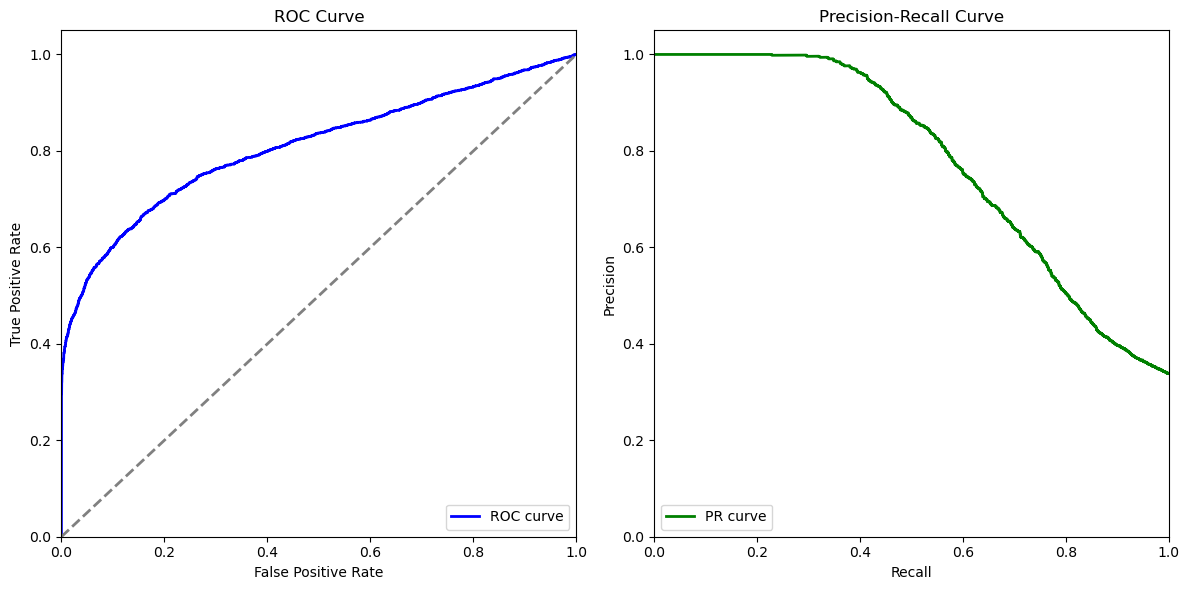

----------------------------
Sampling Method:  distance_under
PCA not applied.
Stratified Train-Test Split:  False
Metrics: {'Accuracy': 0.8262666666666667, 'Precision': 0.8598949211908932, 'Recall': 0.5808359621451105, 'F1-Score': 0.69333960931984, 'AUC-ROC': 0.8295340012760647, 'AUC-PRC': 0.8110549823498091}


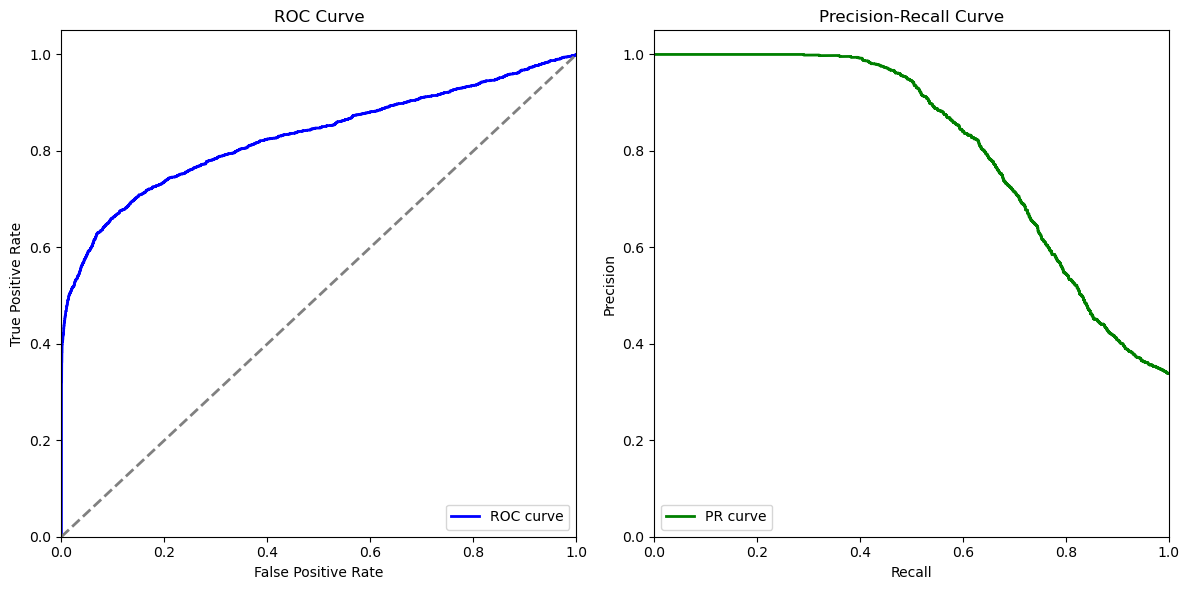

In [31]:
classification_models = ['lr', 'svm', 'xgb', 'softmax']

###### edit here to change classification model ######
clf_idx = 0 # choose from [0,1]
#########################################


print("---------------------------------------------------------------------------")
print(classification_models[clf_idx])
for sampling in ['random_under', 'distance_under']:
    for if_stratified in [True, False]:
        for if_PCA in [True, False]:

            print("----------------------------")

            # sampling
            sampled_edges, sampled_labels = graph_prep.negative_sampling(df, node_embeddings, method=sampling)
            print("Sampling Method: ", sampling)

            if if_PCA:
                # dimensionality reduction
                print("PCA applied. ", end='')
                sampled_edges = graph_prep.perform_pca(sampled_edges)
            else:
                print("PCA not applied.")

            # train-test split
            X_train, X_test, y_train, y_test = graph_prep.edge_train_test_split(sampled_edges, sampled_labels, stratified=if_stratified)
            print("Stratified Train-Test Split: ", if_stratified)

            # LR
            if classification_models[clf_idx] == 'lr':
                lr_clf = tune_hyperparameters(LogisticRegression(max_iter=100000), lr_param_dist, X_train, y_train)
                metrics, roc_data, prc_data = train_evaluate_model(lr_clf, X_train, X_test, y_train, y_test)


            # SVM
            elif classification_models[clf_idx] == 'svm':
                svm_clf = tune_hyperparameters(SVC(probability=True), svm_param_dist, X_train, y_train)
                metrics, roc_data, prc_data = train_evaluate_model(svm_clf, X_train, X_test, y_train, y_test)

            # XGB
            elif classification_models[clf_idx] == 'xgb':
                xgb_clf = tune_hyperparameters(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_param_dist, X_train, y_train)
                metrics, roc_data, prc_data = train_evaluate_model(xgb_clf, X_train, X_test, y_train, y_test)

            elif classification_models[clf_idx] == 'softmax':
                nn_model = SoftmaxNN(X_train.shape[1])
                metrics = train_evaluate_nn(nn_model, X_train, X_test, y_train, y_test)

            else:
                raise ValueError("Invalid value for classification model.")


            ##### Directory for saving results ######
            save_dir = '../res/'+ classification_models[clf_idx]
            os.makedirs(save_dir, exist_ok=True)
            # Convert the metrics to a pandas DataFrame
            metrics_df = pd.DataFrame([metrics])
            save_name = save_dir + '/' + embedding_methods[emd_idx] +'_'+ sampling +'_' + str(if_stratified)
            # Export the DataFrame to a CSV file
            metrics_df.to_csv(save_name+'.csv', index=False)
            # pickle.dump(models[classification_models[clf_idx]], open(f'{save_dir}/{classification_models[clf_idx]}_model.pkl', 'wb'))
            # pd.DataFrame([metrics[classification_models[clf_idx]]]).to_csv(f'{save_dir}/{classification_models[clf_idx]}_metrics.csv', index=False)
            plot_metrics(roc_data, prc_data, save_fig=True, filename=save_name)
            #########################################